In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

In [4]:
locals().update(np.load("result_nonparametric_negative_binomial.npz"))

# 1. Parameters

In [17]:
num_sim = 927
T = Ys_sim.shape[1]

In [18]:
T0 = 20
alpha = 1
K = 6.5

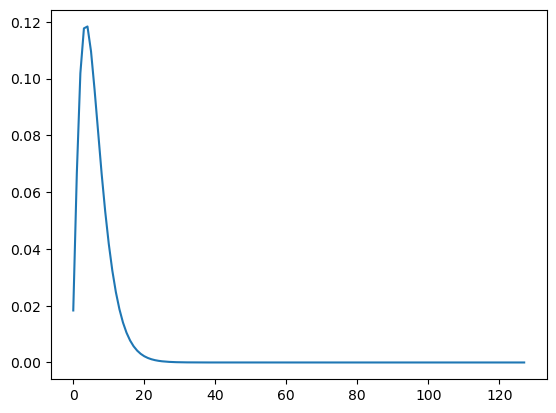

In [19]:
# g
plt.plot(g)

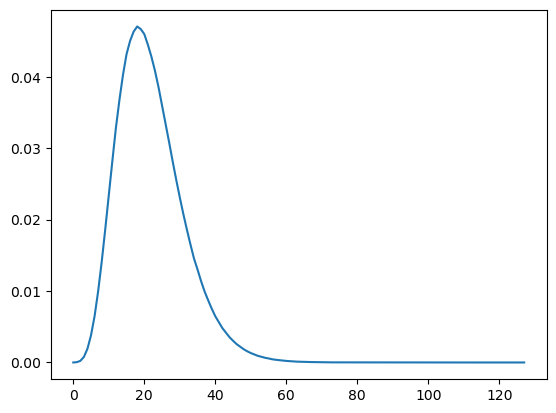

In [20]:
# pi
plt.plot(pi)

In [21]:
# A
d = A.shape[1]

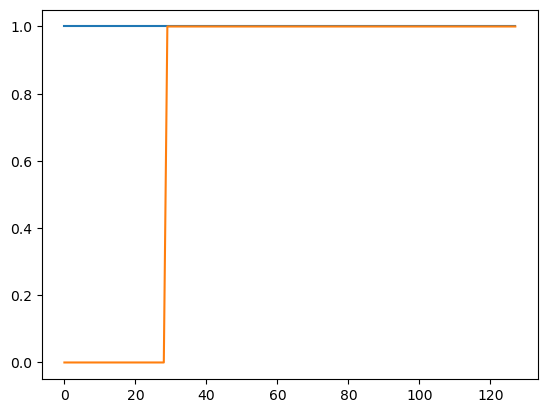

In [22]:
plt.plot(A)

# 3. coverage by Fisher Information Matrix

In [23]:
def NBLL(y, m, r):
    y = int(y)
    return (np.sum(np.log(1+(r-1)/(np.arange(y)+1))) 
            + r * np.log(r/(r+m)) 
            + y * np.log(m/(r+m)))

In [24]:
def dNBLLdr(y, m, r):
    y = int(y)
    return (np.sum(1/(np.arange(y)+r)) + np.log(r/(r+m)) + (m-y)/(r+m))

In [25]:
def d2NBLLdr2(y, m, r):
    y = int(y)
    return (-np.sum(1/(np.arange(y)+r)**2) + 1/r + 1/(r+m) - (m-y)/(r+m)**2)

# 4. Wald's Confidence Region coverage test

In [26]:
Ihs_dth = np.zeros([num_sim, 2+d, 2+d])
Ts_dth = np.zeros(num_sim)
ps_dth = np.zeros(num_sim)

In [27]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    rhat = rsim[iter_sim,-1]
    mhat_0 = msim_0[iter_sim,-1]
    bhat = bsim[iter_sim,-1,:]
    Y_data = Ys_sim[iter_sim]
    
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rh[...,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mhat_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]

    dldEY = Y_data/EY - (rhat+Y_data)/(rhat+EY)
    d2ldEY2 = - Y_data/EY**2 + (rhat+Y_data)/(rhat+EY)**2
    d2ldrdEY = - 1/(rhat+EY) + (rhat+Y_data)/(rhat+EY)**2

    d2ldr2 = np.sum([d2NBLLdr2(y, m, rhat) for y, m in zip(Y_data, EY)])
    d2ldm2 = np.sum(d2ldEY2 * Pi_inv_ImG[:,0]**2)
    d2ldb2 = np.sum(d2ldEY2 * d1EY * d1EY[:,None,:], 2) \
           + np.sum(dldEY * d2EY, 2)

    d2ldrdm = np.sum(d2ldrdEY * Pi_inv_ImG[:,0])
    d2ldrdb = np.sum(d2ldrdEY * d1EY, 1)
    d2ldmdb = np.sum(d2ldEY2 * Pi_inv_ImG[:,0] * d1EY, 1) \
            + np.sum(dldEY * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0], 1)

    d2ldrm2 = np.array([[d2ldr2, d2ldrdm],
                        [d2ldrdm, d2ldm2]])
    d2ldrmdb = np.stack([d2ldrdb, 
                         d2ldmdb])

    Ihs_dth[iter_sim] = - np.block([[d2ldrm2, d2ldrmdb],
                                    [d2ldrmdb.T, d2ldb2]])
    Ts_dth[iter_sim] = (bhat[1]-bmle[1])/np.sqrt(la.inv(Ihs_dth[iter_sim])[-1,-1])
    ps_dth[iter_sim] = 2*(1-stats.norm.cdf(np.abs(Ts_dth[iter_sim])))
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 0.015052 sec.
2-th simulation finished, 0.030363 sec.
3-th simulation finished, 0.006897 sec.
4-th simulation finished, 0.005022 sec.
5-th simulation finished, 0.004817 sec.
6-th simulation finished, 0.003355 sec.
7-th simulation finished, 0.006888 sec.
8-th simulation finished, 0.005891 sec.
9-th simulation finished, 0.005325 sec.
10-th simulation finished, 0.010365 sec.
11-th simulation finished, 0.006928 sec.
12-th simulation finished, 0.007422 sec.
13-th simulation finished, 0.006995 sec.
14-th simulation finished, 0.005769 sec.
15-th simulation finished, 0.005465 sec.
16-th simulation finished, 0.006831 sec.
17-th simulation finished, 0.003867 sec.
18-th simulation finished, 0.005840 sec.
19-th simulation finished, 0.007084 sec.
20-th simulation finished, 0.004331 sec.
21-th simulation finished, 0.005526 sec.
22-th simulation finished, 0.017149 sec.
23-th simulation finished, 0.013431 sec.
24-th simulation finished, 0.007478 sec.
25-th simulation finished

210-th simulation finished, 0.034522 sec.
211-th simulation finished, 0.006643 sec.
212-th simulation finished, 0.012527 sec.
213-th simulation finished, 0.010837 sec.
214-th simulation finished, 0.004741 sec.
215-th simulation finished, 0.003720 sec.
216-th simulation finished, 0.006749 sec.
217-th simulation finished, 0.011568 sec.
218-th simulation finished, 0.006025 sec.
219-th simulation finished, 0.005429 sec.
220-th simulation finished, 0.005339 sec.
221-th simulation finished, 0.006072 sec.
222-th simulation finished, 0.008276 sec.
223-th simulation finished, 0.004542 sec.
224-th simulation finished, 0.005611 sec.
225-th simulation finished, 0.005711 sec.
226-th simulation finished, 0.005742 sec.
227-th simulation finished, 0.004680 sec.
228-th simulation finished, 0.007527 sec.
229-th simulation finished, 0.014521 sec.
230-th simulation finished, 0.011354 sec.
231-th simulation finished, 0.039854 sec.
232-th simulation finished, 0.009050 sec.
233-th simulation finished, 0.0059

433-th simulation finished, 0.015275 sec.
434-th simulation finished, 0.009061 sec.
435-th simulation finished, 0.007502 sec.
436-th simulation finished, 0.005952 sec.
437-th simulation finished, 0.006010 sec.
438-th simulation finished, 0.006196 sec.
439-th simulation finished, 0.005896 sec.
440-th simulation finished, 0.007053 sec.
441-th simulation finished, 0.014247 sec.
442-th simulation finished, 0.006129 sec.
443-th simulation finished, 0.006472 sec.
444-th simulation finished, 0.004498 sec.
445-th simulation finished, 0.005835 sec.
446-th simulation finished, 0.005886 sec.
447-th simulation finished, 0.005219 sec.
448-th simulation finished, 0.004398 sec.
449-th simulation finished, 0.003362 sec.
450-th simulation finished, 0.006711 sec.
451-th simulation finished, 0.004741 sec.
452-th simulation finished, 0.005572 sec.
453-th simulation finished, 0.010750 sec.
454-th simulation finished, 0.007095 sec.
455-th simulation finished, 0.006132 sec.
456-th simulation finished, 0.0059

635-th simulation finished, 0.011094 sec.
636-th simulation finished, 0.008356 sec.
637-th simulation finished, 0.008043 sec.
638-th simulation finished, 0.010278 sec.
639-th simulation finished, 0.007279 sec.
640-th simulation finished, 0.003456 sec.
641-th simulation finished, 0.010417 sec.
642-th simulation finished, 0.008649 sec.
643-th simulation finished, 0.006217 sec.
644-th simulation finished, 0.015877 sec.
645-th simulation finished, 0.005144 sec.
646-th simulation finished, 0.008641 sec.
647-th simulation finished, 0.006492 sec.
648-th simulation finished, 0.003035 sec.
649-th simulation finished, 0.007682 sec.
650-th simulation finished, 0.006940 sec.
651-th simulation finished, 0.006408 sec.
652-th simulation finished, 0.004591 sec.
653-th simulation finished, 0.004013 sec.
654-th simulation finished, 0.006593 sec.
655-th simulation finished, 0.004952 sec.
656-th simulation finished, 0.003844 sec.
657-th simulation finished, 0.005753 sec.
658-th simulation finished, 0.0049

850-th simulation finished, 0.009498 sec.
851-th simulation finished, 0.012866 sec.
852-th simulation finished, 0.012918 sec.
853-th simulation finished, 0.005848 sec.
854-th simulation finished, 0.003239 sec.
855-th simulation finished, 0.010214 sec.
856-th simulation finished, 0.003490 sec.
857-th simulation finished, 0.005746 sec.
858-th simulation finished, 0.006657 sec.
859-th simulation finished, 0.005526 sec.
860-th simulation finished, 0.005857 sec.
861-th simulation finished, 0.007288 sec.
862-th simulation finished, 0.007658 sec.
863-th simulation finished, 0.003183 sec.
864-th simulation finished, 0.005442 sec.
865-th simulation finished, 0.007238 sec.
866-th simulation finished, 0.010094 sec.
867-th simulation finished, 0.005059 sec.
868-th simulation finished, 0.005476 sec.
869-th simulation finished, 0.011333 sec.
870-th simulation finished, 0.010161 sec.
871-th simulation finished, 0.008433 sec.
872-th simulation finished, 0.017382 sec.
873-th simulation finished, 0.0132

(array([ 21.,  43., 164., 201., 230., 147.,  88.,  22.,   6.,   5.]),
 array([-1.96337109, -1.49967189, -1.03597269, -0.57227349, -0.10857429,
         0.35512491,  0.81882411,  1.28252331,  1.74622252,  2.20992172,
         2.67362092]),
 <BarContainer object of 10 artists>)

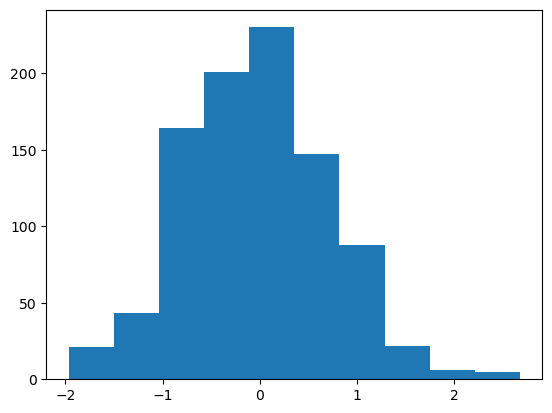

In [28]:
plt.hist(Ts_dth)

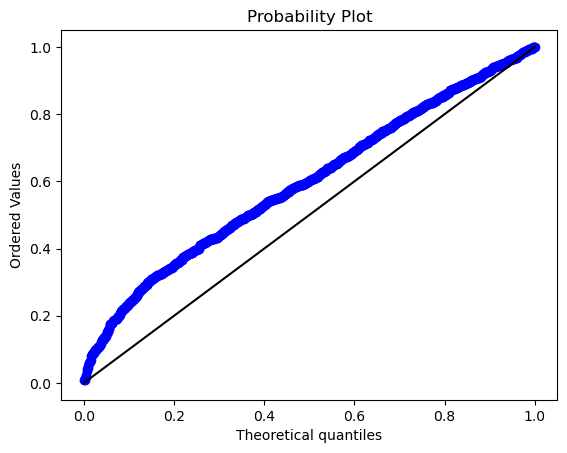

In [40]:
stats.probplot(ps_dth, dist = 'uniform', plot=plt, fit=False)
plt.plot([0, 1], [0, 1], c='black')
plt.show()

In [30]:
np.mean(np.abs(Ts_dth) < stats.norm.ppf(0.975))

0.9902912621359223

# 6. Sandwich estimator coverage test

In [31]:
L_HAC = np.floor(4* (T/100)**(2/9))

In [32]:
w_HAC = np.maximum(1 - np.abs(np.arange(T)[:,None] - np.arange(T))/L_HAC, 0)

In [33]:
Ihs_sdw = np.zeros([num_sim, 2+d, 2+d])
Ts_sdw = np.zeros(num_sim)
ps_sdw = np.zeros(num_sim)

In [34]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    rhat = rsim[iter_sim,-1]
    mhat_0 = msim_0[iter_sim,-1]
    bhat = bsim[iter_sim,-1,:]
    Y_data = Ys_sim[iter_sim]
    
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    d2G = d2Rh[...,None] * np.concatenate([[0],g])[
            np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    inv_ImG = la.inv(np.eye(T+T0)-G)
    Pi_inv_ImG = Pi @ inv_ImG
    
    EY = mhat_0 * Pi_inv_ImG[:,0]
    d1EY = mhat_0 * (Pi_inv_ImG @ (d1G @ inv_ImG[:,:1]))[...,0]
    d2EY = mhat_0 * (Pi_inv_ImG @ (
        d1G[:,None] @ inv_ImG @ d1G @ inv_ImG[:,:1]
        + d1G @ inv_ImG @ d1G[:,None] @ inv_ImG[:,:1]
        + d2G @ inv_ImG[:,:1]))[...,0]
    
    dltdr = np.array([dNBLLdr(y, m, rmle) for y, m in zip(Y_data, EY)])
    dltdm = dldEY * Pi_inv_ImG[:,0]
    dltdb = dldEY * d1EY
    
    dltdth = np.concatenate([np.array([dltdr, dltdm]), dltdb], 0)
    VEdl = dltdth @ w_HAC @ dltdth.T

    Ihs_sdw[iter_sim] = Ihs_dth[iter_sim] @ la.inv(VEdl) @ Ihs_dth[iter_sim]
    Ts_sdw[iter_sim] = (bhat[1]-bmle[1])/np.sqrt(la.inv(Ihs_sdw[iter_sim])[-1,-1])
    ps_sdw[iter_sim] = 2*(1-stats.norm.cdf(np.abs(Ts_sdw[iter_sim])))
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 0.010901 sec.
2-th simulation finished, 0.006352 sec.
3-th simulation finished, 0.007366 sec.
4-th simulation finished, 0.006117 sec.
5-th simulation finished, 0.005620 sec.
6-th simulation finished, 0.005013 sec.
7-th simulation finished, 0.008204 sec.
8-th simulation finished, 0.006564 sec.
9-th simulation finished, 0.004946 sec.
10-th simulation finished, 0.006555 sec.
11-th simulation finished, 0.016100 sec.
12-th simulation finished, 0.006691 sec.
13-th simulation finished, 0.005778 sec.
14-th simulation finished, 0.012827 sec.
15-th simulation finished, 0.008100 sec.
16-th simulation finished, 0.010995 sec.
17-th simulation finished, 0.006874 sec.
18-th simulation finished, 0.006653 sec.
19-th simulation finished, 0.008253 sec.
20-th simulation finished, 0.005830 sec.
21-th simulation finished, 0.009394 sec.
22-th simulation finished, 0.008513 sec.
23-th simulation finished, 0.008887 sec.
24-th simulation finished, 0.004630 sec.
25-th simulation finished

204-th simulation finished, 0.005510 sec.
205-th simulation finished, 0.031603 sec.
206-th simulation finished, 0.008274 sec.
207-th simulation finished, 0.005087 sec.
208-th simulation finished, 0.005392 sec.
209-th simulation finished, 0.007661 sec.
210-th simulation finished, 0.006340 sec.
211-th simulation finished, 0.006419 sec.
212-th simulation finished, 0.005127 sec.
213-th simulation finished, 0.005279 sec.
214-th simulation finished, 0.006001 sec.
215-th simulation finished, 0.005582 sec.
216-th simulation finished, 0.006082 sec.
217-th simulation finished, 0.005869 sec.
218-th simulation finished, 0.007169 sec.
219-th simulation finished, 0.006738 sec.
220-th simulation finished, 0.004516 sec.
221-th simulation finished, 0.004299 sec.
222-th simulation finished, 0.003018 sec.
223-th simulation finished, 0.005985 sec.
224-th simulation finished, 0.006255 sec.
225-th simulation finished, 0.005842 sec.
226-th simulation finished, 0.009956 sec.
227-th simulation finished, 0.0054

406-th simulation finished, 0.003138 sec.
407-th simulation finished, 0.013835 sec.
408-th simulation finished, 0.006534 sec.
409-th simulation finished, 0.012896 sec.
410-th simulation finished, 0.005636 sec.
411-th simulation finished, 0.004597 sec.
412-th simulation finished, 0.006808 sec.
413-th simulation finished, 0.017136 sec.
414-th simulation finished, 0.009148 sec.
415-th simulation finished, 0.007056 sec.
416-th simulation finished, 0.009721 sec.
417-th simulation finished, 0.009771 sec.
418-th simulation finished, 0.011272 sec.
419-th simulation finished, 0.012801 sec.
420-th simulation finished, 0.008379 sec.
421-th simulation finished, 0.007836 sec.
422-th simulation finished, 0.012977 sec.
423-th simulation finished, 0.009756 sec.
424-th simulation finished, 0.010137 sec.
425-th simulation finished, 0.014779 sec.
426-th simulation finished, 0.009361 sec.
427-th simulation finished, 0.013811 sec.
428-th simulation finished, 0.007881 sec.
429-th simulation finished, 0.0059

622-th simulation finished, 0.013190 sec.
623-th simulation finished, 0.010546 sec.
624-th simulation finished, 0.010720 sec.
625-th simulation finished, 0.011169 sec.
626-th simulation finished, 0.006977 sec.
627-th simulation finished, 0.007074 sec.
628-th simulation finished, 0.008737 sec.
629-th simulation finished, 0.007402 sec.
630-th simulation finished, 0.007325 sec.
631-th simulation finished, 0.008134 sec.
632-th simulation finished, 0.006286 sec.
633-th simulation finished, 0.006784 sec.
634-th simulation finished, 0.007125 sec.
635-th simulation finished, 0.007335 sec.
636-th simulation finished, 0.006493 sec.
637-th simulation finished, 0.007688 sec.
638-th simulation finished, 0.005633 sec.
639-th simulation finished, 0.006764 sec.
640-th simulation finished, 0.006760 sec.
641-th simulation finished, 0.005620 sec.
642-th simulation finished, 0.007237 sec.
643-th simulation finished, 0.004565 sec.
644-th simulation finished, 0.006477 sec.
645-th simulation finished, 0.0058

844-th simulation finished, 0.008204 sec.
845-th simulation finished, 0.016557 sec.
846-th simulation finished, 0.005847 sec.
847-th simulation finished, 0.008303 sec.
848-th simulation finished, 0.005551 sec.
849-th simulation finished, 0.004801 sec.
850-th simulation finished, 0.004191 sec.
851-th simulation finished, 0.005428 sec.
852-th simulation finished, 0.007253 sec.
853-th simulation finished, 0.007282 sec.
854-th simulation finished, 0.009842 sec.
855-th simulation finished, 0.011211 sec.
856-th simulation finished, 0.010699 sec.
857-th simulation finished, 0.007482 sec.
858-th simulation finished, 0.004601 sec.
859-th simulation finished, 0.006902 sec.
860-th simulation finished, 0.019517 sec.
861-th simulation finished, 0.005537 sec.
862-th simulation finished, 0.013696 sec.
863-th simulation finished, 0.007558 sec.
864-th simulation finished, 0.005881 sec.
865-th simulation finished, 0.004859 sec.
866-th simulation finished, 0.005660 sec.
867-th simulation finished, 0.0060

(array([ 17.,  56., 260., 326., 175.,  67.,  12.,   7.,   4.,   3.]),
 array([-3.75387234, -2.66757276, -1.58127317, -0.49497359,  0.591326  ,
         1.67762558,  2.76392516,  3.85022475,  4.93652433,  6.02282391,
         7.1091235 ]),
 <BarContainer object of 10 artists>)

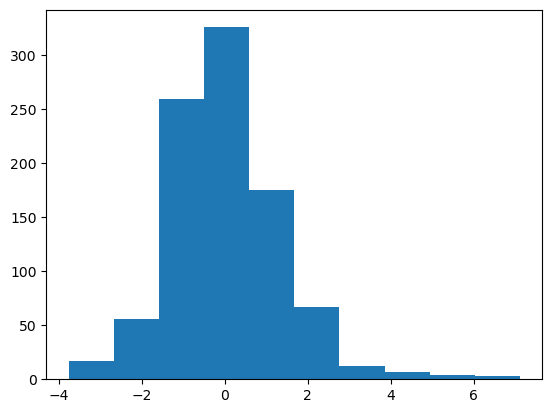

In [35]:
plt.hist(Ts_sdw)

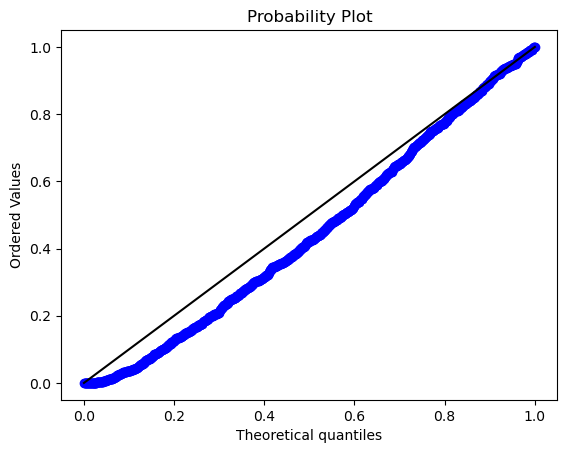

In [41]:
stats.probplot(ps_sdw, dist = 'uniform', plot=plt, fit=False)
plt.plot([0, 1], [0, 1], c='black')
plt.show()

In [37]:
np.mean(np.abs(Ts_sdw) < stats.norm.ppf(0.975))

0.8791801510248112